In [1]:
print("Hello from R in VS Code/Cursor via IRkernel!")
sessionInfo() # 检查 R 版本和加载的包

[1] "Hello from R in VS Code/Cursor via IRkernel!"


R version 4.2.2 (2022-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Rocky Linux 8.10 (Green Obsidian)

Matrix products: default
BLAS:   /apps/R/4.2.2/lib64/R/lib/libRblas.so
LAPACK: /apps/R/4.2.2/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices datasets  utils     methods   base     

loaded via a namespace (and not attached):
 [1] fansi_1.0.3     crayon_1.5.2    utf8_1.2.2      digest_0.6.31  
 [5] IRdisplay_1.1   repr_1.1.7      lifecycle_1.0.3 jsonlite_1.8.4 
 [9] evaluate_0.20   pillar_1.8.1    rlang_1.1.6     cli_3.6.0      
[13] renv_1.1.4      uuid_1.2-1      vctrs_0.6.5  

In [2]:
data.dir = '/projects/compbio/users/rche384/APE/Data/RDA/ASD/LIANA_expr_prod'
set.seed(2018)
library(tensorregress)
library(R.matlab)
library(ggplot2)
library(dplyr)
library(parallel)
library(reticulate)
library(reshape2)
library(gridExtra)

R.matlab v3.7.0 (2022-08-25 21:52:34 UTC) successfully loaded. See ?R.matlab for help.


Attaching package: ‘R.matlab’


The following objects are masked from ‘package:base’:

    getOption, isOpen



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [ ]:
# read in covariates data
cov.mat <- read.table(file.path(data.dir, 'subjects_info.txt'),
                      header = T, sep = '\t') %>% as.data.frame() %>%
  mutate(sex_M = ifelse(sex == 'M', 1, 0),
         Seqbatch_SB1 = ifelse(Seqbatch == 'SB1', 1, 0),
         age = scale(age)[,1],
         diagnosis_ASD = ifelse(diagnosis == 'ASD', 1, 0))

In [4]:
# create design matrix
cov.ind <- as.matrix(cbind('intercept' = rep(1, nrow(cov.mat)),
                           cov.mat[, c('age', 'sex_M',
                                       'Seqbatch_SB1',
                                       'diagnosis_ASD')]))
cov.names = colnames(cov.ind)

In [5]:
mat <- readMat(file.path(data.dir, 'c2ctensor.mat'))
c2ctensor <- as.tensor(mat$c2ctensor)

In [6]:
dim(c2ctensor@data)

[1]   23 2555   17   17

In [7]:
1 - mean(c2ctensor@data != 0)

[1] 0.01925681

In [8]:
lrs = read.table(file.path(data.dir, "lr.txt"),
                 header = F,
                 sep = '\t') %>% unlist()
senders = read.table(file.path(data.dir, "sender.txt"),
                     header = F,
                     sep = '\t')  %>% unlist()
receivers = read.table(file.path(data.dir, "receiver.txt"),
                       header = F,
                       sep = '\t')  %>% unlist()

In [11]:
source('/projects/compbio/users/rche384/APE/R/dcomp.R')

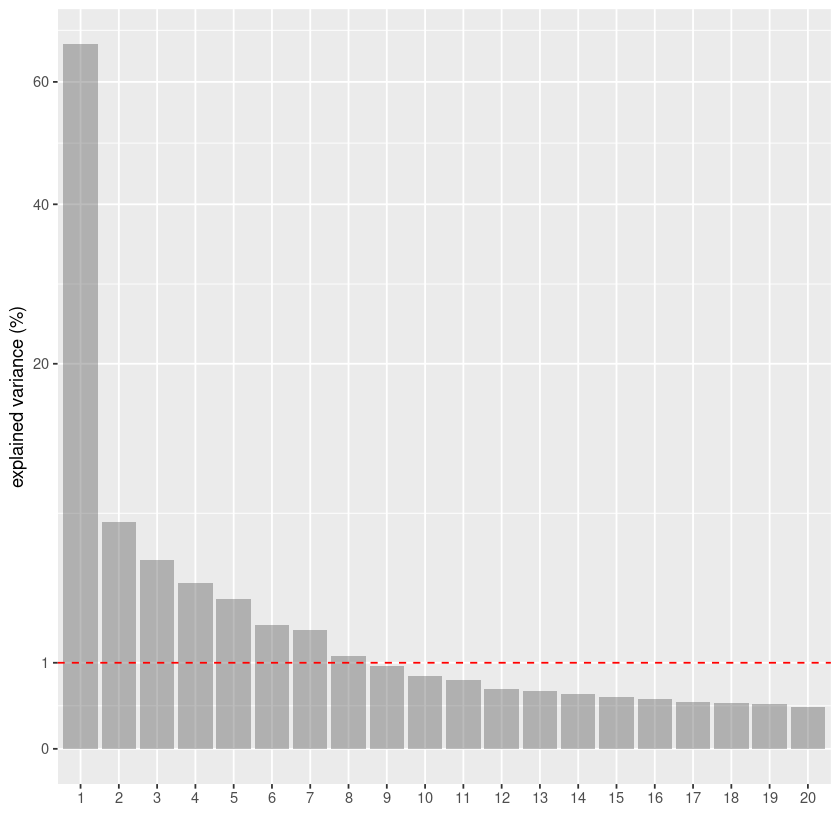

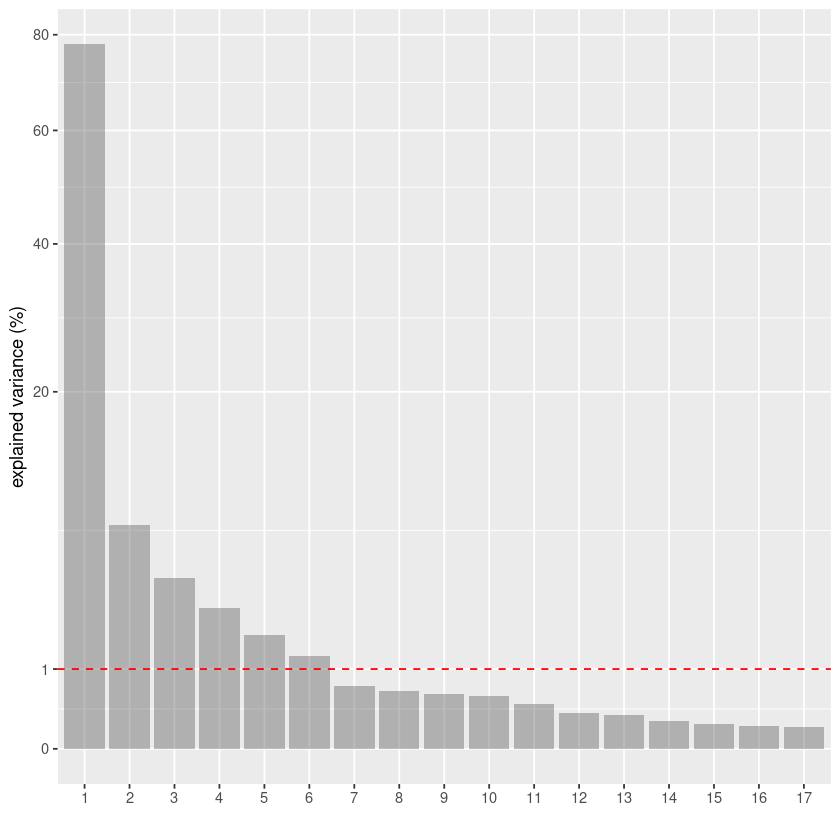

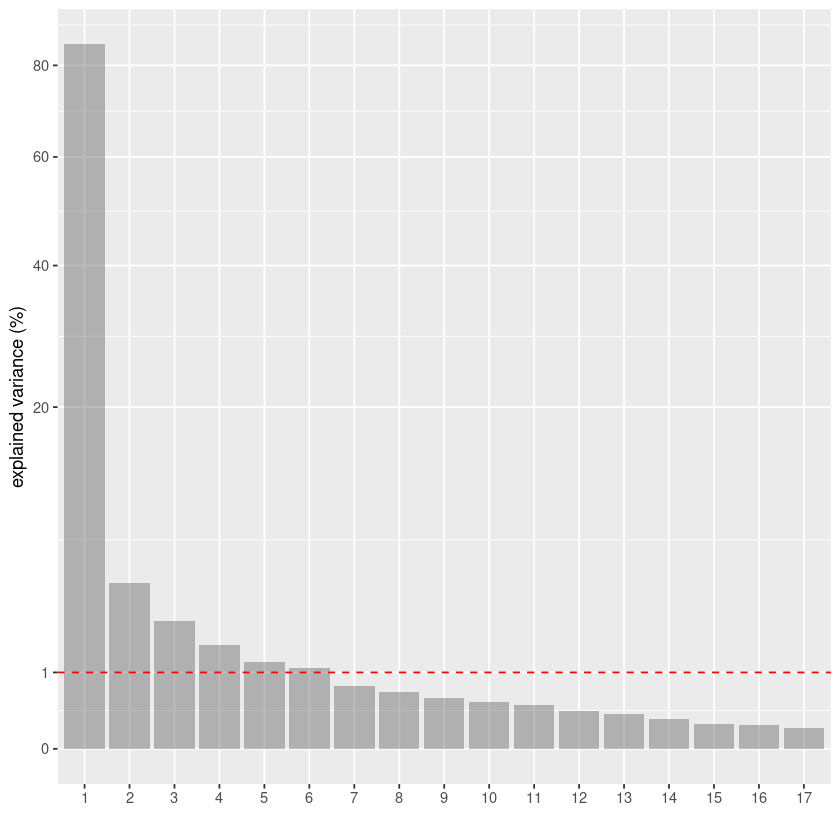

In [12]:
# Determine the number of components for sender cell type
r2 = cal_eigen_varexp(c2ctensor, 2, c(1,3,4), varexp = 1)
# Determine the number of components for receiver cell type
r3 = cal_eigen_varexp(c2ctensor, 3, c(1,2,4), varexp = 1)
# Determine the number of components for ligand-receptor pair
r4 = cal_eigen_varexp(c2ctensor, 4, c(1,2,3), varexp = 1)

plot(r2$p)

plot(r3$p)

plot(r4$p)

In [13]:
# decomposition rank
r = c(ncol(cov.ind), r2$rank, r3$rank, r4$rank)
# staccato
staccato_all_cov = staccato(tsr=c2ctensor,
                            X_covar1=cov.ind,
                            lr.names = lrs,
                            sender.names = senders,
                            receiver.names = receivers,
                            core_shape = r)

  |======================================================================| 100%
  |======================================================================| 100%


In [16]:
disease_eff = get_full_effect(staccato_all_cov$C_ts,
                              var = 'diagnosis_ASD',
                              val = 'effect')

select_pattern = disease_eff %>%
  mutate(Pattern = paste(LR, Sender, Receiver, sep = ' - ')) %>%
  arrange(desc(abs(effect))) %>%
  slice(1:1000) %>%
  dplyr::select(Pattern) %>%
  unlist(.) %>% as.character(.)

disease_eff_top = disease_eff %>%
  mutate(Pattern = paste(LR, Sender, Receiver, sep = ' - ')) %>%
  filter(Pattern %in% select_pattern)

# top_cells = unique(disease_eff_pval$Sender)[8:17]

disease_eff_top$panel <- ifelse(disease_eff_top$Receiver %in% c("AST-FB", "AST-PP", "Endothelial",
                                                                "IN-PV", "IN-SST", "IN-SV2C", "IN-VIP"),
                                "Panel 1", "Panel 2")

max = max(abs(disease_eff_top$effect))

p_compare_receiver_selected = ggplot(disease_eff_top %>%
                                       mutate(Receiver = paste('Receiver:', Receiver)),
                                     aes(Sender, LR)) +    # Create default ggplot2 heatmap
  geom_tile(aes(fill = effect)) +
  scale_fill_gradient2(name = 'Disease Effect',
                       limits = c(-1 * max, max),
                       low = "blue",
                       mid = "white",
                       high = "red",
                       guide = guide_colorbar(barwidth = 30)) +
  theme_linedraw() +
  theme(text = element_text(size = 20, face = 'bold'),
        axis.text.x = element_text(angle=90,vjust = 1, hjust=1),
        legend.position = 'top',
        legend.text = element_text(size = 16),
        strip.background = element_rect(fill = "white"),
        strip.text = element_text(color = 'black')) +
  facet_wrap(~Receiver, ncol = 6) +
  xlab('Sender Cell Types') +
  ylab('Ligand - Receptor Pairs')

# 保存图片并设置尺寸
ggsave("disease_effect_heatmap.png",  # 指定保存的文件名
       plot = p_compare_receiver_selected, # 指定要保存的 ggplot2 对象
       width = 26,         # 设置宽度，单位为英寸
       height = 28)        # 设置高度，单位为英寸


In [17]:
# bootstrap
n_boot = 20
n_thread = 5
P = boot_p(n_boot = n_boot,
           dcomp_res = staccato_all_cov,
           n_thread = n_thread,
           lr.names = lrs,
           sender.names = senders,
           receiver.names = receivers)

In [18]:
disease_pval = get_full_effect(P,
                               var='diagnosis_ASD',
                               val = 'pval')
head(disease_pval)

,Sender,Receiver,LR,pval
,<chr>,<chr>,<fct>,<dbl>
1,AST-FB,AST-FB,A2M^LRP1,0.04761905
2,AST-FB,AST-FB,ACTR2^LDLR,0.52380952
3,AST-FB,AST-FB,ACTR2^LRP2,0.04761905
4,AST-FB,AST-FB,ADAM10^AXL,0.04761905
5,AST-FB,AST-FB,ADAM10^CADM1,0.09523810
6,AST-FB,AST-FB,ADAM10^CD44,0.04761905
